In [ ]:
%pip install hmmlearn
%pip install pgmpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#1.a)
state_probability = np.array([0.33333, 0.33333, 0.33333])#easy-medium-difficult
n_states = len(state_probability)
transition_probability = np.array([[0.25, 0.25, 0.5],
                                   [0.25, 0.25, 0.5],
                                   [0.5, 0.5, 0]])
emission_probability = np.array([[0.2, 0.3, 0.4, 0.1],
                                [0.15, 0.25, 0.5, 0.1],
                                [0.1, 0.2, 0.4, 0.3]])


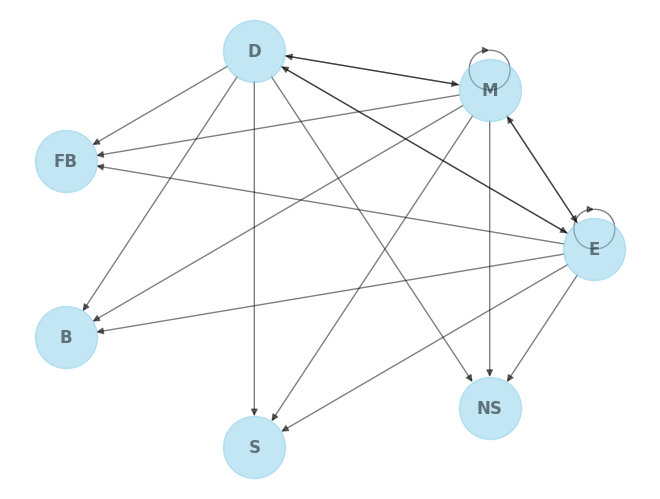

In [ ]:
to_draw_model = nx.DiGraph()
edges = [('E','E'),('E','M'),('E','D'),
         ('M','E'),('M','M'),('M','D'),
         ('D','M'),('D','E'),
         ('E','FB'),('E','B'),('E','S'),('E','NS'),
         ('M','FB'),('M','B'),('M','S'),('M','NS'),
         ('D','FB'),('D','B'),('D','S'),('D','NS')]

to_draw_model.add_edges_from(edges)

pos = nx.circular_layout(to_draw_model)
nx.draw(to_draw_model, with_labels=True, pos=pos, alpha=0.5,
        node_size=2000, font_weight='bold', node_color='skyblue',
        arrows=True)

plt.show()

In [ ]:
model = hmm.CategoricalHMM(n_components=n_states)
model.startprob_ = state_probability
model.transmat_ = transition_probability
model.emissionprob_ = emission_probability

#observabile: fb -> 0
#             b -> 1
#             s -> 2
#             ns -> 3

In [ ]:
#1.b)
observations_sequence = np.array([0,0,2,1,1,2,1,1,3,1,1]).reshape(-1, 1)
prob_obs = model.score(observations_sequence, lengths = len(observations_sequence))
print('Probability of the sequence of observations is:',np.exp(prob_obs))

Probability of the sequence of observations is: 1.6887976316423815e-07


In [ ]:
#1.c)
hidden_states = model.predict(observations_sequence)
print("Most likely hidden states:", hidden_states)

log_probability, hidden_states = model.decode(observations_sequence,
                                              lengths = len(observations_sequence),
                                              algorithm ='viterbi' )

print('Log Probability :',log_probability)
print("Most likely hidden states:", hidden_states)

Most likely hidden states: [2 0 2 0 2 1 2 0 2 0 2]
Log Probability : -23.195759966785847
Most likely hidden states: [2 0 2 0 2 1 2 0 2 0 2]


In [ ]:
#bonus)
def viterbi_log(startprob, transmat, emitmat, obs):
    N = startprob.shape[0]
    T = len(obs)
    log_start = np.log(startprob, where=(startprob>0), out=np.full_like(startprob, -np.inf, dtype=float))
    log_trans = np.log(transmat, where=(transmat>0), out=np.full_like(transmat, -np.inf, dtype=float))
    log_emit = np.log(emitmat, where=(emitmat>0), out=np.full_like(emitmat, -np.inf, dtype=float))
    
    V = np.full((T, N), -np.inf)
    backpointer = np.zeros((T, N), dtype=int)
    
    for s in range(N):
        V[0, s] = float(log_start[s].item()) + float(log_emit[s, obs[0]].item())
        backpointer[0, s] = 0
    
    for t in range(1, T):
      for s in range(N):
          candidates = V[t-1, :] + log_trans[:, s] + log_emit[s, obs[t]]
          max_idx = N - 1 - np.argmax(candidates[::-1])
          backpointer[t, s] = max_idx
          V[t, s] = candidates[max_idx]
    
    last_state = np.argmax(V[T-1, :])
    best_path = np.zeros(T, dtype=int)
    best_path[T-1] = last_state
    for t in range(T-2, -1, -1):
        best_path[t] = backpointer[t+1, best_path[t+1]]
    
    best_logprob = V[T-1, best_path[T-1]]
    return best_logprob, best_path, V, backpointer


In [ ]:
best_logprob, best_path, V_matrix, bp = viterbi_log(state_probability, transition_probability, emission_probability, observations_sequence)

print("Log probability:", best_logprob)
print("Most likely hidden states:", best_path)